In [1]:
# This line solves some minor problems when you do not have propery set the PYTHONPATH
exec(compile(open("fix_paths.py", "rb").read(), "fix_paths.py", 'exec'))

## Load data example

In [2]:
from common import dataset_loaders
original_labels = dataset_loaders.groundlabels_dataframe()
map_category = {'A':'Moto', 'B':'Car', 'C':'Car', 'D':'Car', 'E':'Car', 'F':'Car', 'G':'Car', 'H':'Van', 'I':'Bus'}


# Plot data example

In [3]:
from common import plot_utils
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 15)

Populating the interactive namespace from numpy and matplotlib


In [9]:
from common import dataset_loaders
import pandas as pd


## Load the labels the same way we loaded them to run the first stage prediction
original_labels = dataset_loaders.groundlabels_dataframe()



In [10]:

# This line solves some minor problems when you do not have propery set the PYTHONPATH
exec(compile(open("fix_paths.py", "rb").read(), "fix_paths.py", 'exec'))

import settings
import os
import pandas as pd
from common import dataset_loaders
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from patch_generators.pos_and_negative_fix_size import LabelEncoding, data_generator
import time

# Inicialization

## Pretrained model... I think it will be good to start from here and not from scratch
INPUT_MODEL = '%s/patches_single_size/models/all_discriminator_remote.hdf5' % (settings.DATAMODEL_PATH)

## Name of the new experiment and the new file where we will save the new output model
experiment_name = 'all_resnet_fps'
OUTPUT_MODEL = '%s/%s/models/fps_discriminator.hdf5' % (settings.DATAMODEL_PATH, experiment_folder_name)

## Provide data to locate the fp file
fp_file_path = "%s/patches_single_size/annotations/%s" % (settings.DATAMODEL_PATH, fp_filename)


# Parameters
image_size_nn = 48
num_valid_cases = 120
patch_size = 110
batch_size = 25
big_batch_size, valid_batch_size = 2500, 480
restart_valid_train = False



# We create the data structure we need
experiment_folder_name = 'patches_single_size_fps'
os.system('mkdir -p %s/%s' % (settings.DATAMODEL_PATH, experiment_folder_name))
os.system('mkdir -p %s/%s/models' % (settings.DATAMODEL_PATH, experiment_folder_name))
os.system('mkdir -p %s/%s/logs' % (settings.DATAMODEL_PATH, experiment_folder_name))
LOGS_PATH    = '%s/%s/logs/%s' % (settings.DATAMODEL_PATH, experiment_folder_name, experiment_name)

# Load the FP dataframe
fps_data = pd.read_csv(fp_file_path, header =None)
fps_data.columns = ['image','fp','x','y']


def load_labels(restart_valid_train):
    # Generate consistent train and validation sets
    ## Only do this if the train / validation has not been generated yet
    original_labels = dataset_loaders.groundlabels_dataframe()
    if restart_valid_train == True:
        os.system('rm -f %s/%s/train_df.csv' % (settings.DATAMODEL_PATH, experiment_folder_name))
        os.system('rm -f %s/%s/valid_df.csv' % (settings.DATAMODEL_PATH, experiment_folder_name))

    if not os.path.exists('%s/%s/train_df.csv' % (settings.DATAMODEL_PATH, experiment_folder_name)) and not os.path.exists('%s/%s/valid_df.csv' % (settings.DATAMODEL_PATH, experiment_folder_name)):
        cases = original_labels['image'].unique()
        np.random.shuffle(cases)
        train_data = original_labels[original_labels.image.isin(cases[num_valid_cases:])]
        valid_data = original_labels[~original_labels.image.isin(cases[num_valid_cases:])]

        train_data.to_csv('%s/%s/train_df.csv' % (settings.DATAMODEL_PATH, experiment_folder_name), index = False)
        valid_data.to_csv('%s/%s/valid_df.csv' % (settings.DATAMODEL_PATH, experiment_folder_name), index = False)
    train_data = pd.read_csv('%s/%s/train_df.csv' % (settings.DATAMODEL_PATH, experiment_folder_name))
    valid_data = pd.read_csv('%s/%s/valid_df.csv' % (settings.DATAMODEL_PATH, experiment_folder_name))
    return original_labels, train_data, valid_data

original_labels, train_data, valid_data = load_labels(restart_valid_train)

# Initialize these cases
## We add background as label to the rest of existing labels
existing_labels = np.concatenate([original_labels['class'].unique(), ['background']])
labelencoder = LabelEncoding(existing_labels)
data_augmentation = ImageDataGenerator(vertical_flip=True, horizontal_flip = True, zoom_range = 0.02, rotation_range=180)

train_generator = data_generator(data_augmentation, labelencoder, train_data, batch_size=big_batch_size, min_buffer_before_start = 5000, patch_size=patch_size, image_size_nn=image_size_nn, df_FP = fps_data)
valid_generator = data_generator(None, labelencoder, valid_data, batch_size=valid_batch_size,  min_buffer_before_start = 1000, patch_size=patch_size, image_size_nn=image_size_nn, df_FP = fps_data)



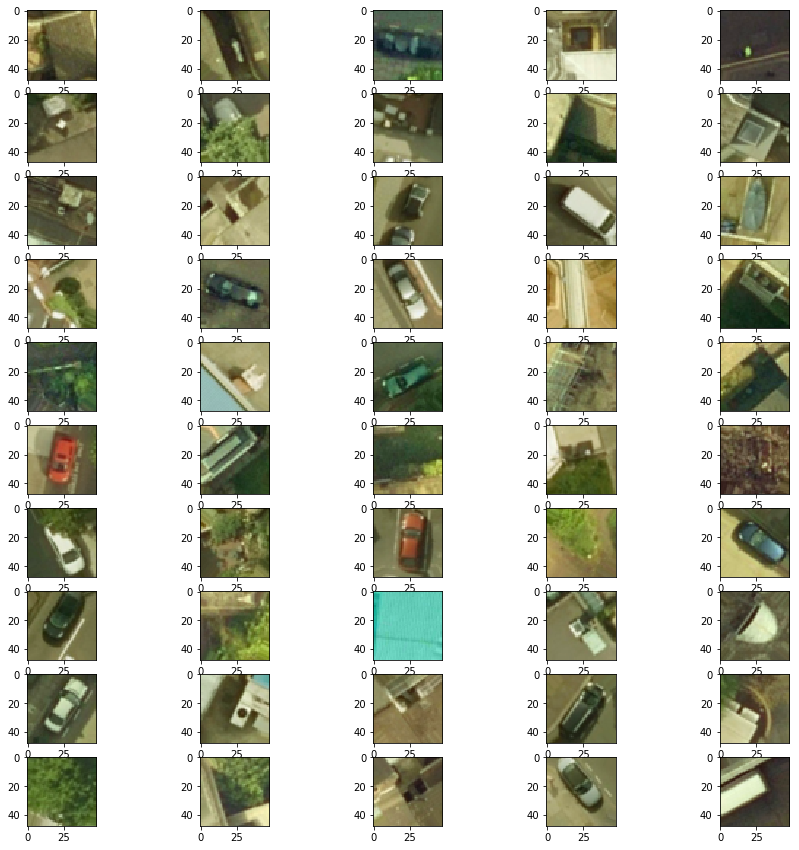

In [12]:
for x,y  in train_generator:
    break
plot_utils.multidraw(images=x.transpose(0,2,3,1), shape = (10,5) )

In [ ]:
x,y = generatePatches_from_image(  train_data.image.values[0], train_data, patch_size, 
                                   quant_negative_patches = 10, negative_patch_label = 'background', 
                                   df_FP = fps_data)
plot_utils.multidraw(images= x, shape = (10,5) )